In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['vgg_face.csv', 'vgg_facebase_line_de.csv', 'vgg_face (1).csv', 'vgg_face (3).csv', 'vgg_face (2).csv', 'sub_detect_kinship.csv']


In [8]:
sub1 = pd.read_csv('./input/vgg_face.csv')
sub2 = pd.read_csv('./input/vgg_face (1).csv')
sub3 = pd.read_csv('./input/vgg_face (2).csv')
sub4 = pd.read_csv('./input/vgg_face (3).csv')
sub5 = pd.read_csv('./input/sub_detect_kinship.csv')
sub6 = pd.read_csv('./input/vgg_facebase_line_de.csv')
temp = pd.read_csv('./input/vgg_face (1).csv')


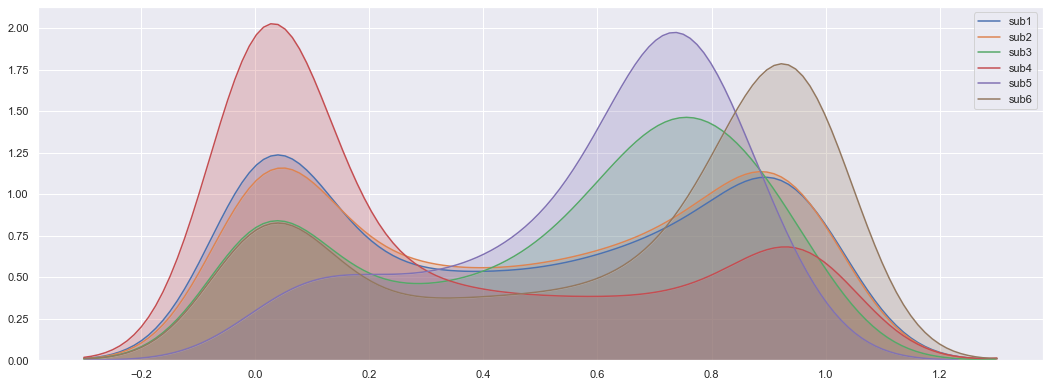

In [9]:
sns.set(rc={'figure.figsize':(18,6.5)})
sns.kdeplot(sub1['is_related'],label="sub1",shade=True,bw=.1)
sns.kdeplot(sub2['is_related'], label="sub2",shade=True,bw=.1)
sns.kdeplot(sub3['is_related'], label="sub3",shade=True,bw=.1)
sns.kdeplot(sub4['is_related'], label="sub4",shade=True,bw=.1)
sns.kdeplot(sub5['is_related'], label="sub5",shade=True,bw=.1)
sns.kdeplot(sub6['is_related'], label="sub6",shade=True,bw=.1)

In [12]:
temp['is_related'] = 0.50*sub1['is_related'] + 0.50*sub6['is_related']  
temp.to_csv('submission1.csv', index=False )

In [ ]:
net.summary()

In [ ]:


img = image.load_img('face.jpg',target_size=(197,197))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = utils.preprocess_input(x,version=2)
fm = net.predict(x)

print(fm.shape)


In [ ]:
from keras.models import Model

model = VGGFace(include_top=False, model='resnet50')
model = Model(model.input,model.layers[-2].output)
input = Input(shape=(224, 224, 3))
for x in model.layers[:-2]:
    x.trainable = True
output = model(input)
net = Model(input, output)
net.summary()


In [ ]:

img = image.load_img('face.jpg',target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = utils.preprocess_input(x,version=2)
res = net.predict(x)
res.shape

In [ ]:
net.layers


In [ ]:
img = image.load_img('face.jpg',target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = utils.preprocess_input(x,version=2)
res = net.predict(x)
res.shape

### siamese network for https://www.kaggle.com/c/recognizing-faces-in-the-wild

In [ ]:

from collections import defaultdict
from glob import glob
from random import choice, sample

import cv2
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract
from keras.models import Model
from keras.optimizers import Adam
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace

In [ ]:
train_file_path = "Faces_in_the_Wild/train_relationships.csv"
train_folders_path = "Faces_in_the_Wild/train/"
val_famillies = "F09"

all_images = glob(train_folders_path + "*/*/*.jpg")

train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]

In [ ]:
len(val_images)

In [ ]:

train_person_to_images_map = defaultdict(list)

ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]

In [ ]:
for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

In [ ]:
val_person_to_images_map = defaultdict(list)

for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

In [ ]:
relationships = pd.read_csv(train_file_path)
relationships = list(zip(relationships.p1.values, relationships.p2.values))
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]

In [ ]:
train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]

In [ ]:
def read_img(path):
    img = cv2.imread(path)
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

In [ ]:
def gen(list_tuples, person_to_images_map, batch_size=16):
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])

        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img(x) for x in X1])

        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img(x) for x in X2])

        yield [X1, X2], labels

In [ ]:
def baseline_model():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    # x1_ = Reshape(target_shape=(7*7, 2048))(x1)
    # x2_ = Reshape(target_shape=(7*7, 2048))(x2)
    #
    # x_dot = Dot(axes=[2, 2], normalize=True)([x1_, x2_])
    # x_dot = Flatten()(x_dot)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x = Multiply()([x1, x2])

    x = Concatenate(axis=-1)([x, x3])

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

    model.summary()

    return model

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot([1,2,3],[2,4,3])

In [ ]:
import joblib

In [ ]:
epoch_info = joblib.load('epoch_info1560485905.540373.pkl')

In [ ]:
loss_list = [ [x,epoch_info[x]['loss'],epoch_info[x]['acc']] for x in epoch_info]

In [ ]:
len(loss_list)

In [ ]:
loss_list

In [ ]:
import numpy as np
loss_list = np.array(loss_list)

In [ ]:
plt.plot(loss_list[:, 0], loss_list[:, 1])


In [ ]:
plt.plot(loss_list[:, 0], loss_list[:, 2])

In [ ]:
from torch import nn

In [ ]:
m = nn.Bilinear(20,30,40)
import torch

In [ ]:
import numpy as np

input1 = torch.randn(128, 20)
input2 = torch.randn(128, 30)
output = m(input1, input2)
print(output.size())
arr_output = output.data.cpu().numpy()

weight = m.weight.data.cpu().numpy()
bias = m.bias.data.cpu().numpy()
x1 = input1.data.cpu().numpy()
x2 = input2.data.cpu().numpy()

print(x1.shape, weight.shape, x2.shape, bias.shape)
y = np.zeros((x1.shape[0], weight.shape[0]))

for k in range(weight.shape[0]):
    buff = np.dot(x1, weight[k])
    buff = buff * x2
    buff = np.sum(buff, axis=1)
    y[:, k] = buff

y += bias
dif = y - arr_output
print(np.mean(np.abs(dif.flatten())))


In [ ]:
train_file_path = "Faces_in_the_Wild/train_relationships.csv"

In [ ]:
import pandas as pd
relationships = pd.read_csv(train_file_path)
relationships = list(zip(relationships.p1.values, relationships.p2.values))

In [ ]:
len(relationships)

In [ ]:
labels = set([])
for x1, x2 in relationships:
    labels.add(x1)
    labels.add(x2)
    

In [ ]:
len(labels
    )

In [ ]:
train_folders_path = "Faces_in_the_Wild/train/"


In [ ]:
from glob import glob

In [ ]:
all_images = glob(train_folders_path + "*/*/*.jpg")

In [ ]:
len(all_images)